In [1]:
import re
import time
import nltk
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from gensim.models import word2vec
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

/home/italojs/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Download it if you never used nltk-top words before

In [2]:
# nltk.download('stopwords')

## Loading the dataset

In [3]:
with open("imdb_labelled.txt") as f:
    lines = f.readlines()

## Visualizing some basic infos

In [4]:
print("Lines count:", len(lines))
i = 5
print("First {} lines:\n".format(i), lines[:i])

Lines count: 1000
First 5 lines:
 ['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  \t0\n', 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  \t0\n', 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  \t0\n', 'Very little music or anything to speak of.  \t0\n', 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  \t1\n']


## Processing the dataset
I don't analyzed the datset yet, but it's a word datset, so, first of all, i will remove the stop words and clean the sentences(removing numbers, commas, dots and etc)

In [5]:

def remove_stop_words(sentence, stop_words):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', sentence).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if len(word) == 0:
            sentence.remove(word)
            continue
        if word in stop_words:
            sentence.remove(word)  
    return sentence

## spliting the revews and labels

In [6]:
reviews = []
labels =  []
    
stop_words = nltk.corpus.stopwords.words()

#removing whitespace characters like `\n` at the end of each line
lines = [x.strip() for x in lines] 
# spliting the examples and the labels
for line in lines:
    temp = line.split("\t")
    review = temp[0].lower()
    review = remove_stop_words(review, stop_words)
    reviews.append(review)
    labels.append(temp[1])

## Basic reviews visualization

In [7]:
print("Reviews count:", len(reviews))
i = 2
print("First {} reviews:\n".format(i), reviews[:i])

Reviews count: 1000
First 2 reviews:
 [['slowmoving', 'aimless', 'movie', 'distressed', 'drifting', 'young'], ['sure', 'lost', 'flat', 'characters', 'audience', 'nearly', 'half', 'walked']]


## Trying find outliers words and analyze if it make sense to positive or negative labels

In [8]:
def plot_pos_neg_labels(neg_labels, pos_labels, neg_values, pos_values, limit=1):
    neg_labels = neg_labels[:limit]
    neg_values = neg_values[:limit]
    pos_labels = pos_labels[:limit]
    pos_values = pos_values[:limit]

    neg_indexes = np.arange(len(neg_labels))
    pos_indexes = np.arange(len(pos_labels))

    plt.rcParams["figure.figsize"] = (20,10)

    plt.bar(neg_indexes, neg_values)
    # add labels
    plt.xticks(neg_indexes, neg_labels)
    plt.title('negative words', fontsize=20)
    plt.show()


    plt.bar(pos_indexes, pos_values)
    # add labels
    plt.xticks(pos_indexes, pos_labels)
    plt.title('positive words', fontsize=20)
    plt.show()

In [9]:
def frequence_words(sentences):
    pos_word_list = []
    neg_word_list = []
    for i, line in enumerate(sentences):
        for w in line:
            if labels[i] == "0":
                neg_word_list.append(w)
            else: pos_word_list.append(w)

    neg_counts = Counter(neg_word_list)
    pos_counts = Counter(pos_word_list)

    neg_labels, neg_values = zip(*neg_counts.items())
    pos_labels, pos_values = zip(*pos_counts.items())

    # sort your values in descending order
    neg_indSort = np.argsort(neg_values)[::-1]
    pos_indSort = np.argsort(pos_values)[::-1]

    # rearrange your data
    neg_labels = np.array(neg_labels)[neg_indSort]
    neg_values = np.array(neg_values)[neg_indSort]

    pos_labels = np.array(pos_labels)[pos_indSort]
    pos_values = np.array(pos_values)[pos_indSort]
    return {
        "negative": {
            "values": neg_values,
            "labels": neg_labels
        },
        "positive":{
            "values": pos_values,
            "labels": pos_labels
        }
    }

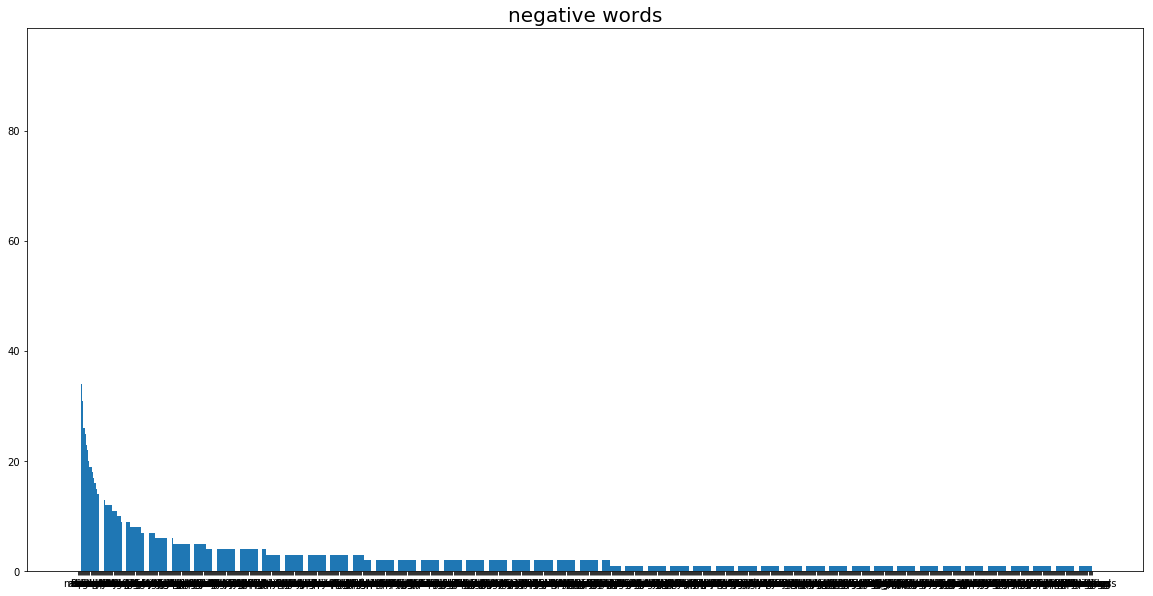

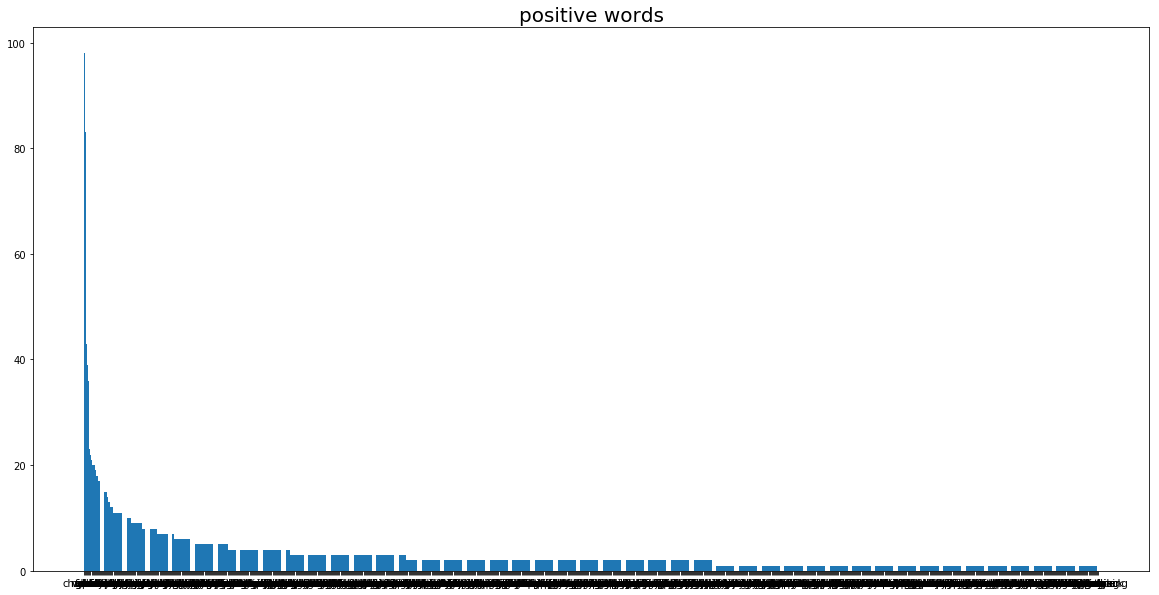

In [10]:

content = frequence_words(reviews)
lenPos = len(content['positive']['values'])
lenNeg = len(content['negative']['values'])
if lenPos > lenNeg:
    limit = lenPos//2
else:
    limit = lenNeg//2

plot_pos_neg_labels(content['negative']['labels'],content['positive']['labels'],
                    content['negative']['values'],content['positive']['values'],
                    limit=limit )

## It seem that we have outliers words, let's go see it closer

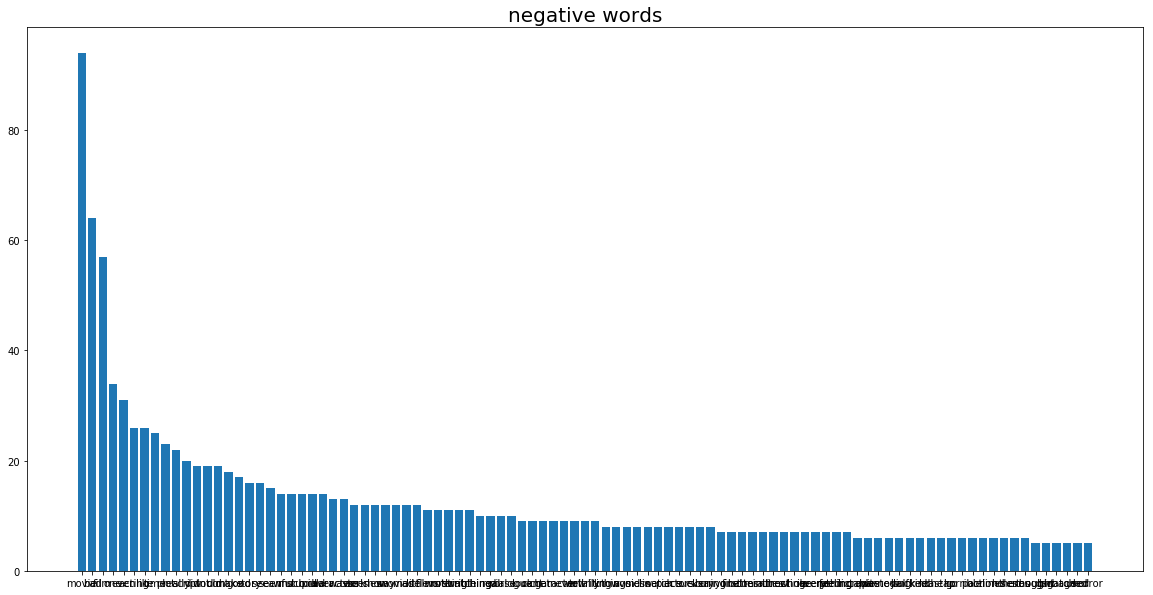

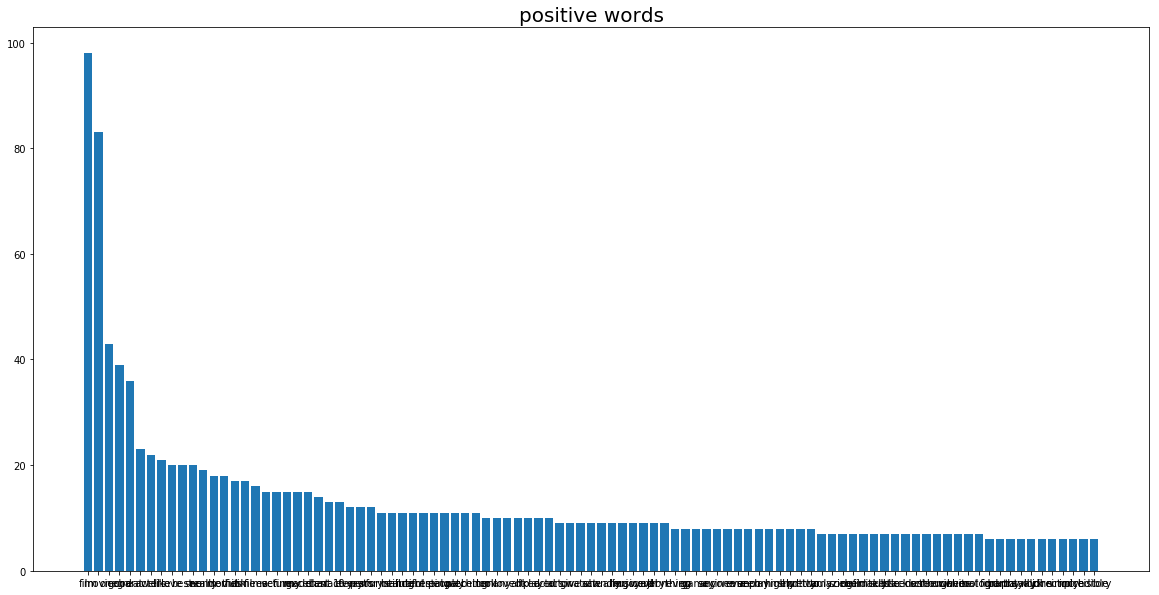

In [11]:
plot_pos_neg_labels(content['negative']['labels'],content['positive']['labels'],
                    content['negative']['values'],content['positive']['values'],
                    limit=limit//10)

## Getting the first 20 words
seems that after the row ~10 the dataset is balanced

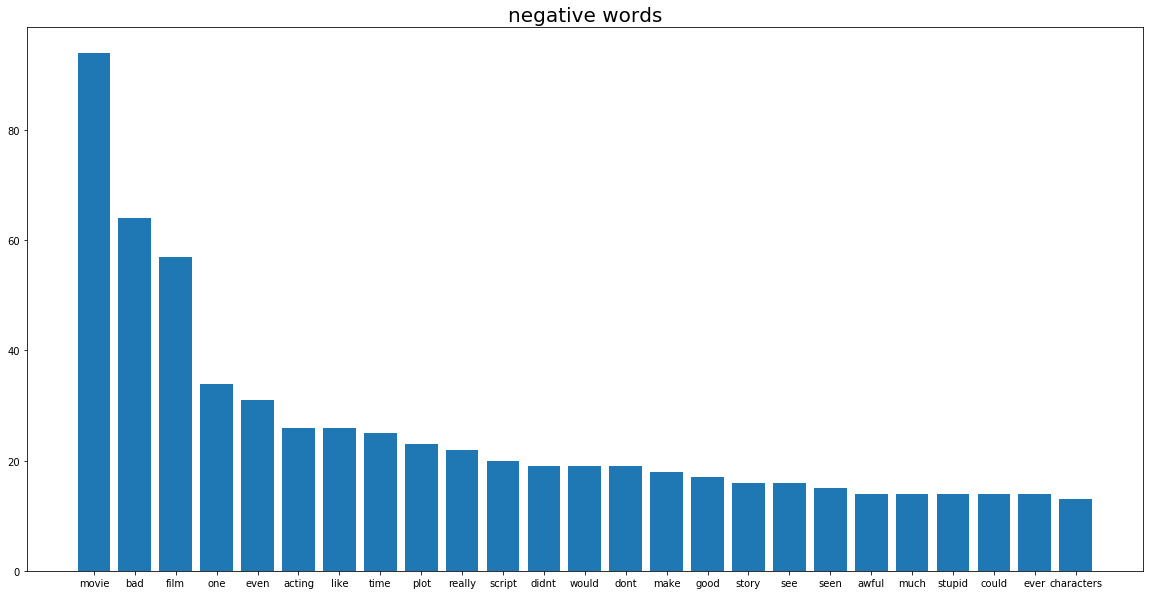

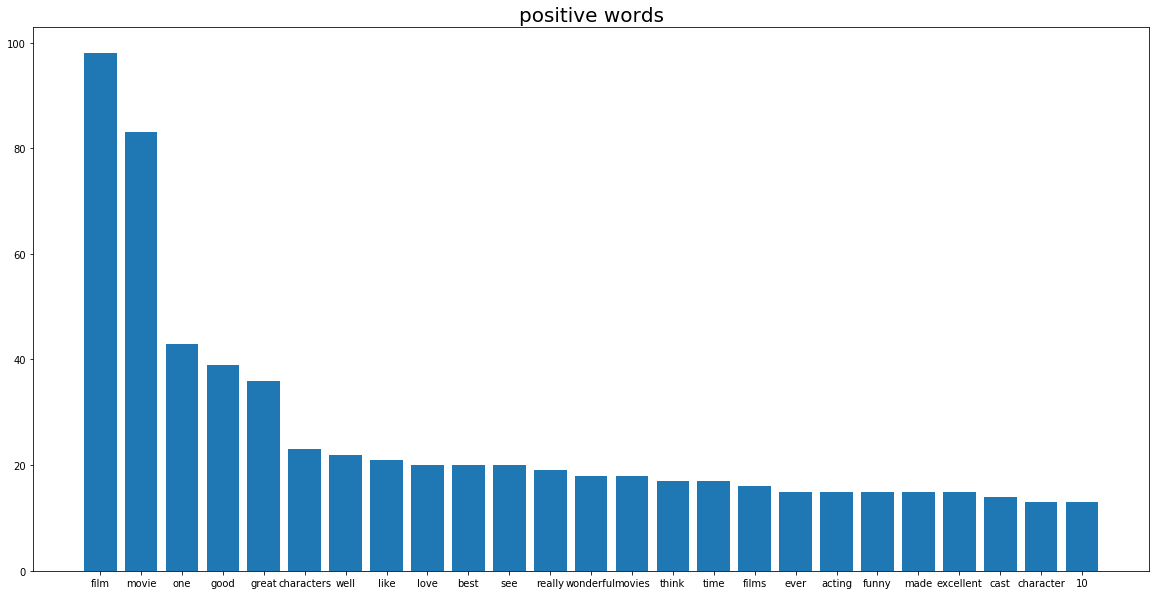

In [12]:
plot_pos_neg_labels(content['negative']['labels'],content['positive']['labels'],
                    content['negative']['values'],content['positive']['values'],
                    limit=25)

## Removing some words from our dataset
Some words that have a super hight frequency may influence the classification results when it's on sentece, some words make sente have this influence like 'good' or 'great', the probability of this word are positive is very higth, but words like 'film' or 'movie' have the same probability to be negative, so we will remove this super high frequence words to have a balanceated datset

In [13]:

final_reviews = []
#i runned many times the last cell to see what's the hight frequence words
#that don't make sense to positive or negative labels
stop_words = ['film','movie','one','characters','work','real', 'never',
              'actually','many','saw',
              'story','say','show','made','cast','every','years','look','character',
              'go','first','seen','even','everything','two','game',
              'even','acting','see','really','scene','character','watching','actors',
              'art','started','white','yet','effects','family','tv','thats','that','long',
              'films','watch','10','story','writing','much','time','ever','scenes',
              'played','line','get''cinema','play','say','never','dont','however',
              'scene','movies','think','script','make','whaching','piece','totally','lines',
              'thing', 'way', 'still', 'people','dialogue','black','know',]
#removing whitespace characters like `\n` at the end of each line
for review in reviews:
    review = " ".join(review)
    final_reviews.append(remove_stop_words(review, stop_words))


## verifing if all reviews is here

In [14]:
print(len(final_reviews))
print(len(labels))

1000
1000


## Verifing if all is balanced now

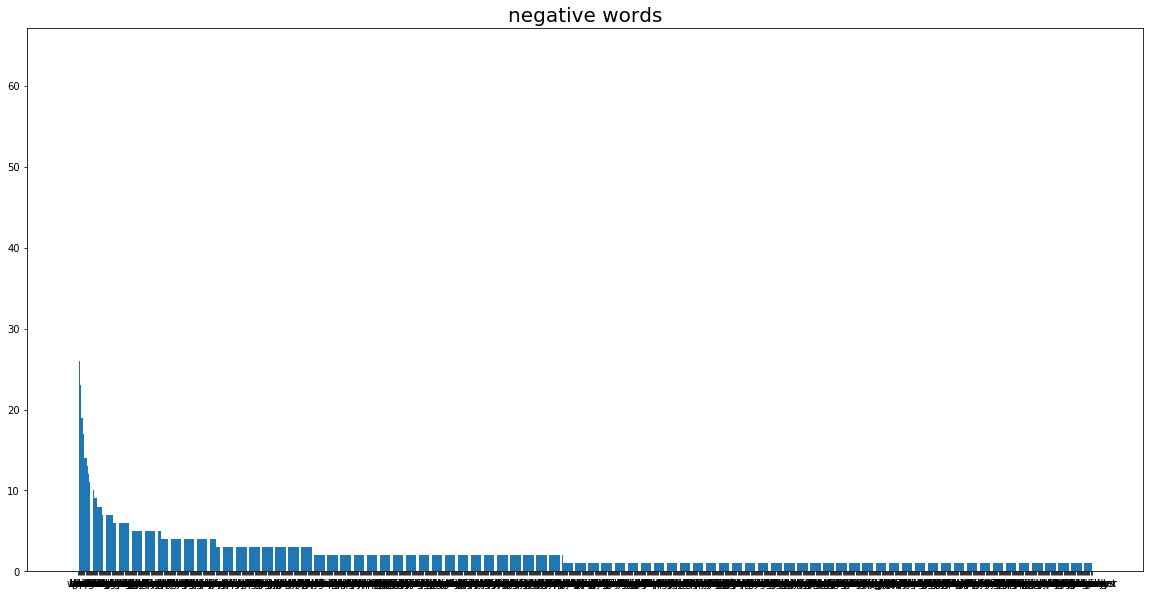

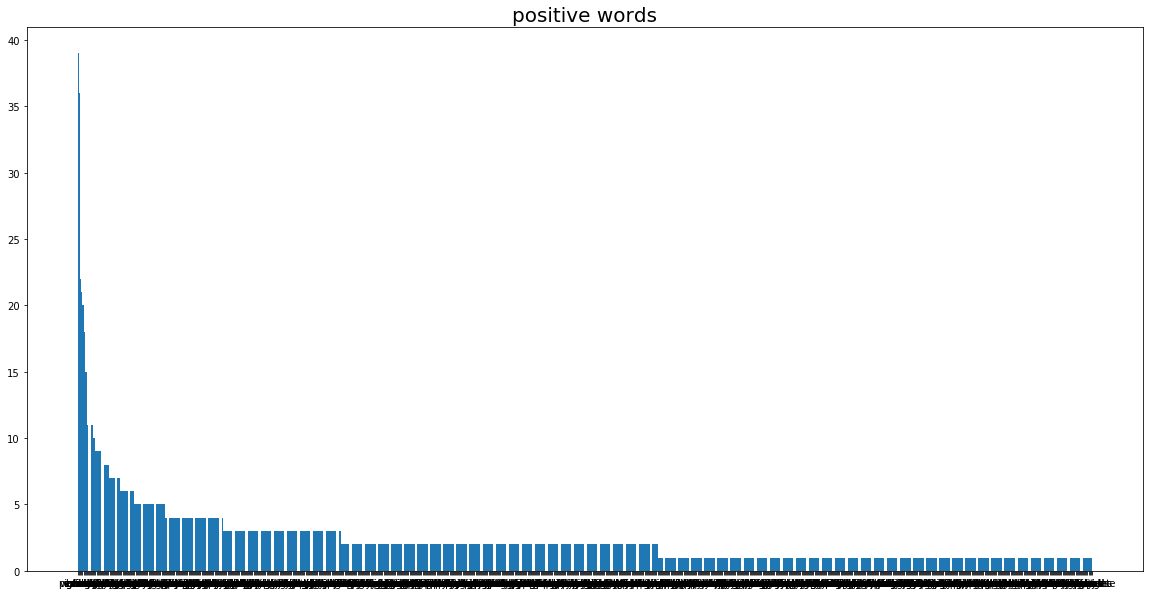

In [15]:
content = frequence_words(final_reviews)
lenPos = len(content['positive']['values'])
lenNeg = len(content['negative']['values'])
if lenPos > lenNeg:
    limit = lenPos//2
else:
    limit = lenNeg//2

plot_pos_neg_labels(content['negative']['labels'],content['positive']['labels'],
                    content['negative']['values'],content['positive']['values'],
                    limit=limit )

## it seems that the positive words dataset is very unbalanced, it's a bad thing because it overfiting our model to some specific good words, let's go see what's this words that are unbalanceding our datset

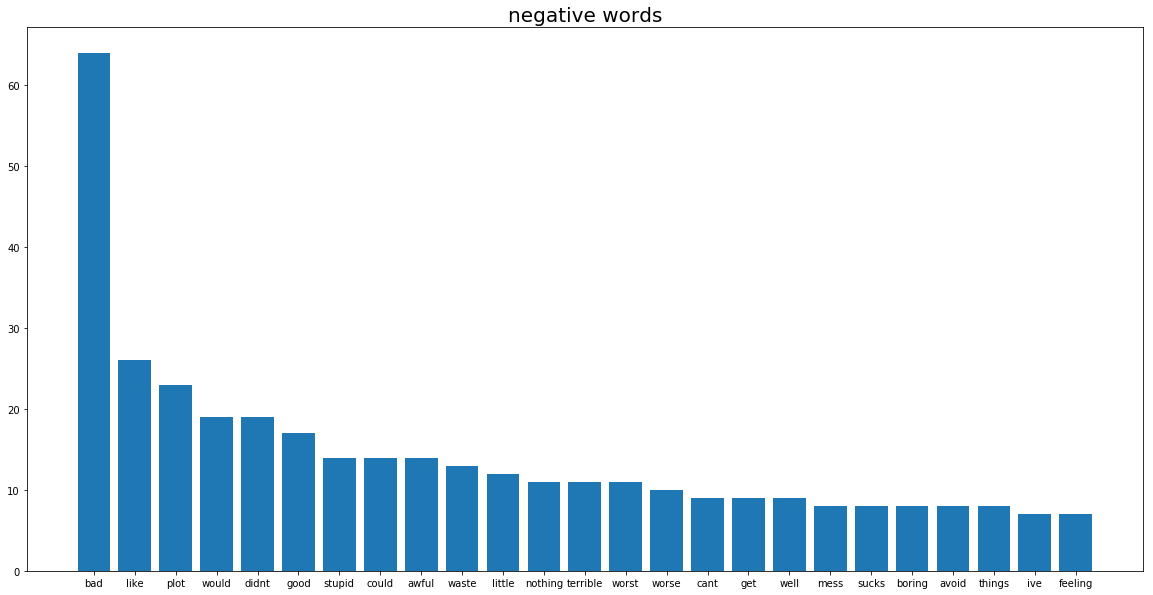

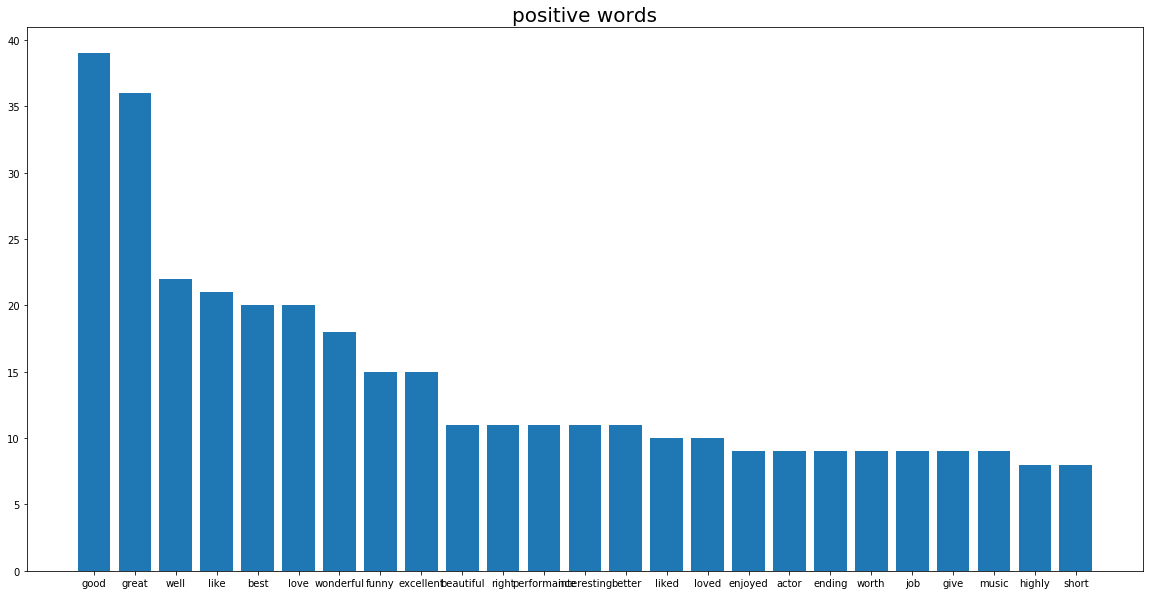

In [16]:
plot_pos_neg_labels(content['negative']['labels'],content['positive']['labels'],
                    content['negative']['values'],content['positive']['values'],
                    limit=25)

## This words make sense is into positive datset, buuuuut, it have so much the same words to positive sentences, it can overfit our model  making predict a sentence as 'positive' every time it's find a 'good' word or a 'great' word, and it's can be an false positive'

let's remove 2/4 of the 'good', 'great,'well'... words

In [17]:
reviews = []
#i runned many times the last cell to see what's the hight frequence words
#that don't make sense to positive or negative labels
stop_words = ['good','well','great','like','love','wonderful',
              'best','excellent','beatful','bad']

  
#removing whitespace characters like `\n` at the end of each line
flag = True
for sentence in final_reviews:
#     review = " ".join(review)
    for word in list(sentence):
        if (word in stop_words) and (flag == True):
            sentence.remove(word)
    flag = not flag
    reviews.append(sentence)



## Let's go see the result

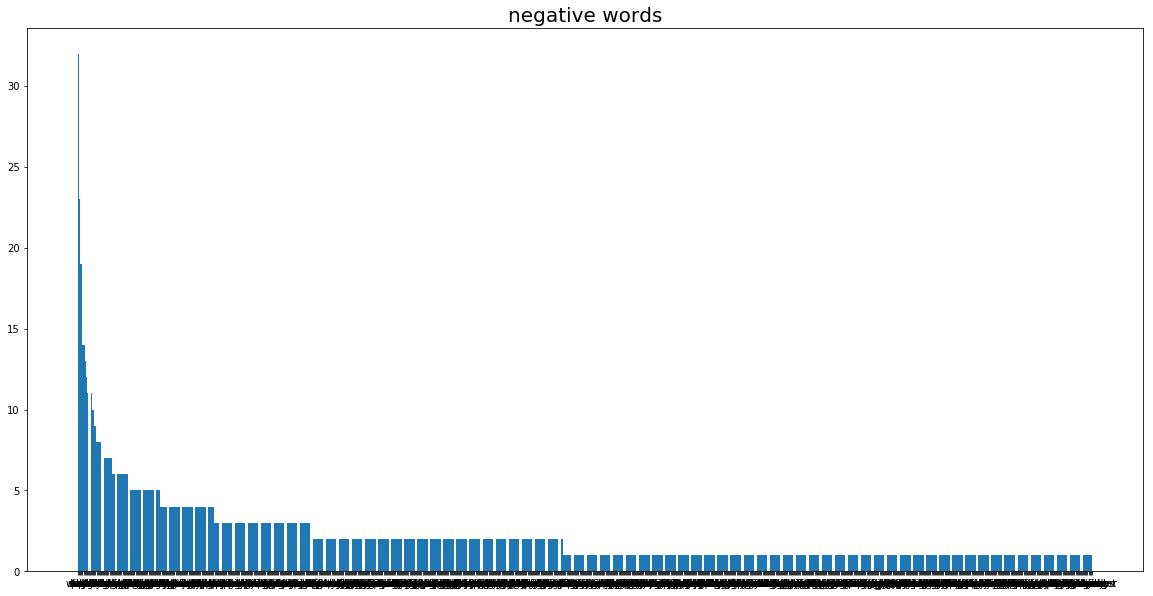

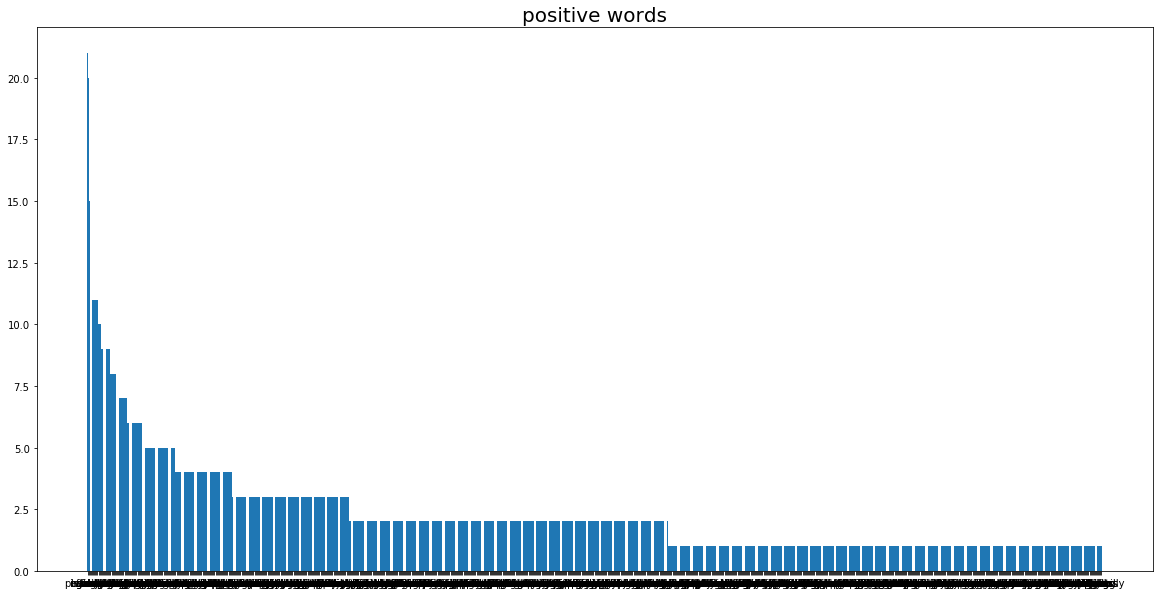

In [18]:
content = frequence_words(reviews)
lenPos = len(content['positive']['values'])
lenNeg = len(content['negative']['values'])
if lenPos > lenNeg:
    limit = lenPos//2
else:
    limit = lenNeg//2

plot_pos_neg_labels(content['negative']['labels'],content['positive']['labels'],
                    content['negative']['values'],content['positive']['values'],
                    limit=limit )


## OK, now it's better
don't forget to look the y scale

## Free memory

In [19]:
del final_reviews
del lines
del stop_words

## Word2Vec

In [20]:
model = word2vec.Word2Vec(reviews, min_count=1)

In [21]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/italojs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


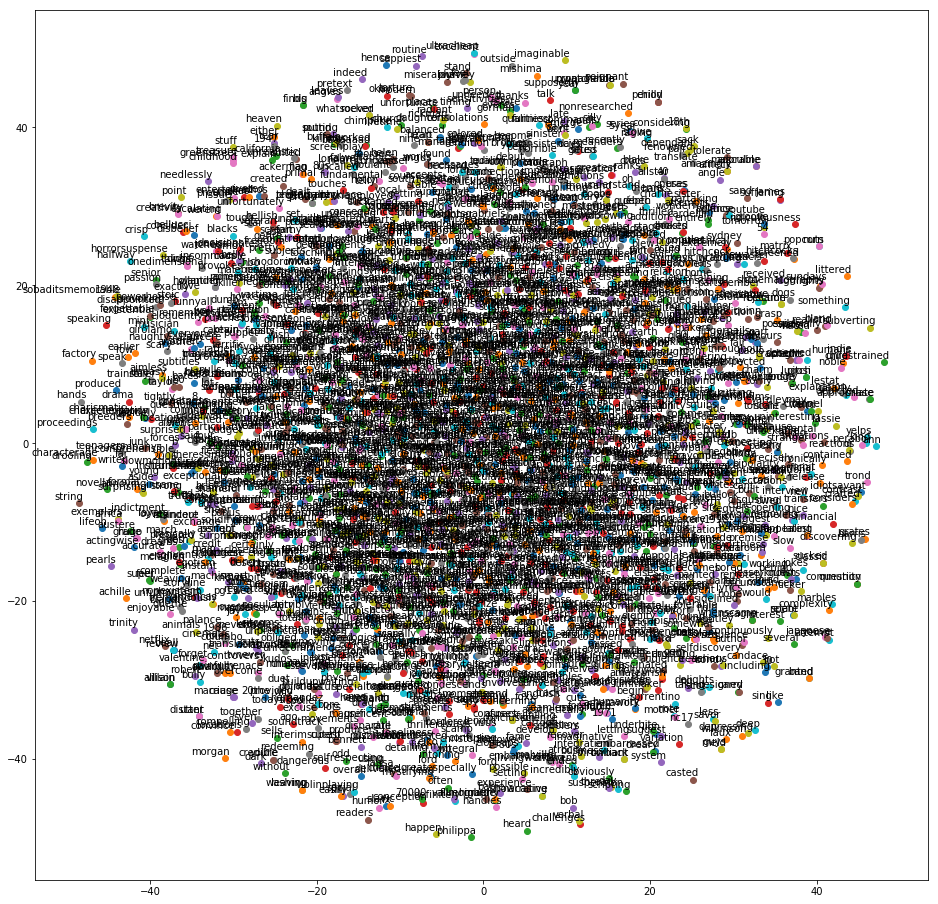

In [22]:
tsne_plot(model)

In [23]:
data = []
for w in reviews:
    data.append(" ".join(w))

## Creatting a feature vector

In [24]:
vectorizer = TfidfVectorizer()

## Spliting dataset

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

## Trainning a Linear SVC (Support Vector Classifier)
like it's a sentment analisys with 2 labels only, i can used a simple naives bayes that is powerful to work with text, but i believed that Linear SVM is faster than naive bayes when it will predict the new sentences labels, but it's lower then NB to train. 

In [58]:
classifier_linear = svm.LinearSVC()
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
print('time to train: ', t1-t0)

time to train:  0.0067138671875


In [59]:
t0 = time.time()
classifier_linear.fit(train_vectors, y_train)
t1 = time.time()
print('time to train: ', t1-t0)

time to train:  0.004512310028076172


In [60]:
t0 = time.time()
predictions = classifier_linear.predict(test_vectors)
t1 = time.time()
print('time to predict: ', t1-t0)

time to predict:  0.0004019737243652344


## Some metrics

In [73]:
print("Results for LinearSVC()")
print(classification_report(y_test, predictions))

Results for LinearSVC()
             precision    recall  f1-score   support

          0       0.77      0.78      0.77       126
          1       0.77      0.77      0.77       124

avg / total       0.77      0.77      0.77       250



In [67]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure() 
    
    plt.title(title) 
    plt.xlabel("Training examples") 
    plt.ylabel("Score") 
    
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes) 
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1) 
    
    plt.grid() 
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r") 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score") 
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score") 
    
    plt.legend(loc="best") 
    return plt 

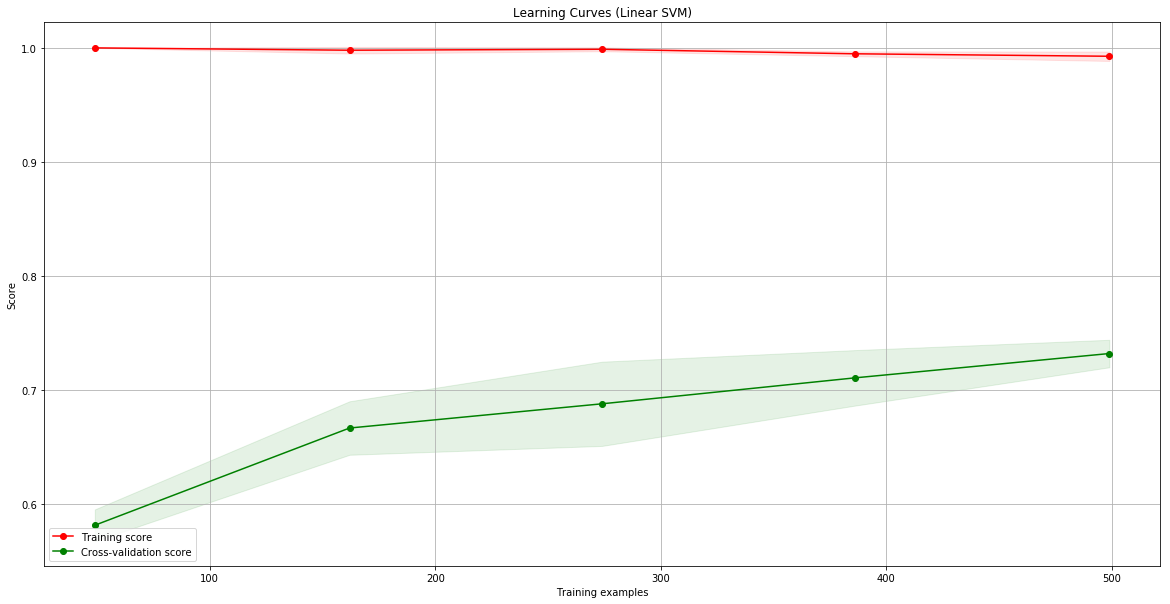

In [72]:
title = "Learning Curves (Linear SVM)"
estimator = svm.LinearSVC() 
plot_learning_curve(estimator, title, train_vectors, y_train, cv=10) 
plt.show()